# 构建项目的模板

所有的项目都可以分为以下6个步骤：
1. 定义问题
2. 总结数据
3. 准备数据
4. 评估算法
5. 改善结果
6. 呈现结果

## 机器学习项目模板

## 模板摘要

```python
# Python Project Template
# 1. Prepare Problem
# a) Load libraries
# b) Load dataset

# 2. Summarize Data
# a) Descriptive statistics
# b) Data visualizations

# 3. Prepare Data
# a) Data Cleaning
# b) Feature Selection
# c) Data Transforms

# 4. Evaluate Algorithms
# a) Split-out validation dataset
# b) Test options and evaluation metric
# c) Spot Check Algorithms
# d) Compare Algorithms

# 5. Improve Accuracy
# a) Algorithm Tuning
# b) Ensembles

# 6. Finalize Model
# a) Predictions on validation dataset
# b) Create standalone model on entire training dataset
# c) Save model for later use
```

# 第一个项目

## 读取数据

### 导入库

有意思的是不能直接`sklearn.datasets`会报错，只能`from sklearn import datasets`：

In [1]:
import pandas as pd
from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

### 读取数据集

In [70]:
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
dataset = read_csv('iris.csv',
                   skiprows=1,
                   header=None,
                   names=names,
                   index_col=0)

## 分析数据

### 数据集维度

In [71]:
print(dataset.shape)

(150, 5)


### 看看数据本身

In [72]:
dataset.head(10)

,sepal-length,sepal-width,petal-length,petal-width,class
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa
7,4.6,3.4,1.4,0.3,setosa
8,5.0,3.4,1.5,0.2,setosa
9,4.4,2.9,1.4,0.2,setosa
10,4.9,3.1,1.5,0.1,setosa


### 描述性统计

In [73]:
print(dataset.describe())

       sepal-length  sepal-width  petal-length  petal-width
count       150.000      150.000       150.000      150.000
mean          5.843        3.057         3.758        1.199
std           0.828        0.436         1.765        0.762
min           4.300        2.000         1.000        0.100
25%           5.100        2.800         1.600        0.300
50%           5.800        3.000         4.350        1.300
75%           6.400        3.300         5.100        1.800
max           7.900        4.400         6.900        2.500


### 类别的分布

In [74]:
dataset.groupby('class').size()

class
setosa        50
versicolor    50
virginica     50
dtype: int64

## 数据可视化

- 单变量图更好地理解每个属性。
- 多元图更好地理解属性之间的关系。

### 单变量

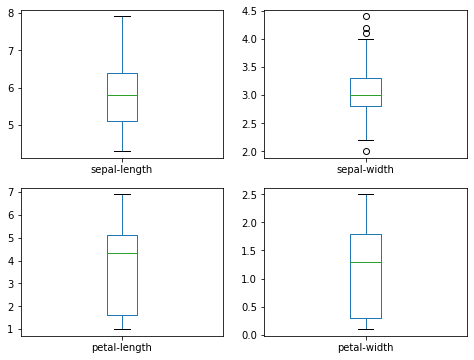

In [7]:
dataset.plot(kind='box',
             subplots=True,
             layout=(2, 2),
             sharex=False,
             sharey=False,
             figsize=(8, 6));

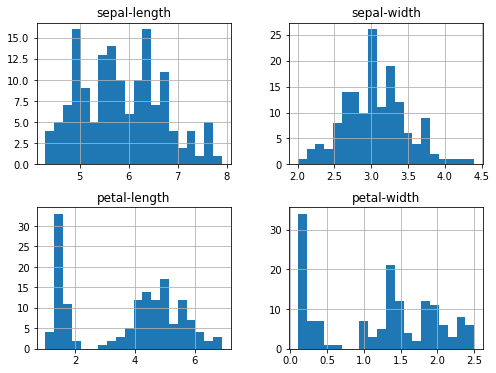

In [8]:
dataset.hist(bins=20, figsize=(8, 6));

### 多元图

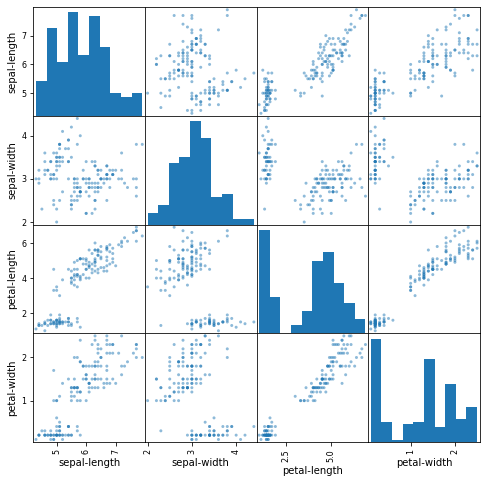

In [9]:
scatter_matrix(dataset, figsize=(8, 8));

## 评估某些算法

### 创建验证集

In [79]:
array = dataset.values
X = array[:, :-1]
Y = array[:, -1]
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(
    X, Y, test_size=validation_size, random_state=7)

### 测试各种模型

In [93]:
models = {
    'LR': LogisticRegression(max_iter=200),
    'LDA': LinearDiscriminantAnalysis(),
    'KNN': KNeighborsClassifier(),
    'CART': DecisionTreeClassifier(),
    'NB': GaussianNB(),
    'SVM': SVC(),
}
results = {}
for name, model in models.items():
    kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model,
                                 X_train,
                                 Y_train,
                                 cv=kfold,
                                 scoring='accuracy')
    results[name] = cv_results
    print("{:<5}: {:>5.3f} ({:.3f})".format(name, cv_results.mean(),
                                            cv_results.std()))

LR   : 0.983 (0.033)
LDA  : 0.975 (0.038)
KNN  : 0.983 (0.033)
CART : 0.950 (0.076)
NB   : 0.967 (0.041)
SVM  : 0.983 (0.033)


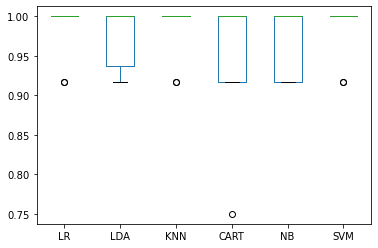

In [83]:
pd.DataFrame(results).plot(kind='box');

## 优化模型

可见KNN、LR和SVM表现比较好，这里选取KNN算法进行预测，书上没有包含数据标准化，尝试添加此步骤：

In [84]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

estimators = []
estimators.append(('standalize', StandardScaler()))
estimators.append(('knn', KNeighborsClassifier()))
pipe = Pipeline(estimators)

param_grid = {
    'knn__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9],  # 可以将pipe和grid合并在一起，通过双下划线指定向pipe中的哪个步骤传递参数
}
grid = GridSearchCV(estimator=pipe, param_grid=param_grid)
grid.fit(X_train, Y_train)
grid.best_score_

0.975

In [85]:
grid.best_params_

{'knn__n_neighbors': 7}

对数据标准化以后，发现准确率反而变低，`n_neighbors`参数变大，模型性能并没有变得更好。有可能的原因是原始数据不同的属性单位都是一样的，因此人为的对原始数据进行缩放，反而丢失了一部分信息。

## 做出预测

In [97]:
lr = LogisticRegression(max_iter=200)

In [98]:
lr.fit(X_train, Y_train)

LogisticRegression(max_iter=200)

In [99]:
lr.predict(X_validation)

array(['virginica', 'versicolor', 'setosa', 'versicolor', 'versicolor',
       'setosa', 'versicolor', 'versicolor', 'setosa', 'versicolor',
       'virginica', 'versicolor', 'setosa', 'virginica', 'setosa',
       'virginica', 'virginica', 'virginica', 'setosa', 'setosa',
       'versicolor', 'virginica', 'versicolor', 'versicolor', 'virginica',
       'virginica', 'versicolor', 'versicolor', 'virginica', 'virginica'],
      dtype=object)

In [86]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)
predictions = knn.predict(X_validation)
print(accuracy_score(Y_validation, predictions))

0.9


In [16]:
print(confusion_matrix(Y_validation, predictions))

[[ 7  0  0]
 [ 0 11  1]
 [ 0  2  9]]


In [17]:
print(classification_report(Y_validation, predictions))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00         7
  versicolor       0.85      0.92      0.88        12
   virginica       0.90      0.82      0.86        11

    accuracy                           0.90        30
   macro avg       0.92      0.91      0.91        30
weighted avg       0.90      0.90      0.90        30



# 回归机器学习案例

## 读取数据

### 读入各种库

In [18]:
import numpy
from numpy import arange
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error

### 读取数据

In [19]:
filename = 'housing.data'
names = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
    'PTRATIO', 'B', 'LSTAT', 'MEDV'
]
dataset = read_csv(filename, delim_whitespace=True, names=names)

## 分析数据

### 数据维度

In [20]:
dataset.shape

(506, 14)

### 查看属性类型

In [21]:
dataset.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

### 查看数据本身

可以看到数据不同属性的单位不一致，后期对数据进行缩放可能会有益：

In [22]:
dataset.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


### 描述性统计

In [23]:
set_option('precision', 2)
dataset.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,5.06e+02,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00
mean,3.61e+00,11.36,11.14,0.07,0.55,6.28,68.57,3.80,9.55,408.24,18.46,356.67,12.65,22.53
std,8.60e+00,23.32,6.86,0.25,0.12,0.70,28.15,2.11,8.71,168.54,2.16,91.29,7.14,9.20
min,6.32e-03,0.00,0.46,0.00,0.39,3.56,2.90,1.13,1.00,187.00,12.60,0.32,1.73,5.00
25%,8.20e-02,0.00,5.19,0.00,0.45,5.89,45.02,2.10,4.00,279.00,17.40,375.38,6.95,17.02
50%,2.57e-01,0.00,9.69,0.00,0.54,6.21,77.50,3.21,5.00,330.00,19.05,391.44,11.36,21.20
75%,3.68e+00,12.50,18.10,0.00,0.62,6.62,94.07,5.19,24.00,666.00,20.20,396.23,16.96,25.00
max,8.90e+01,100.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,22.00,396.90,37.97,50.00


### 查看相关性

In [24]:
dataset.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.00,-0.20,0.41,-5.59e-02,0.42,-0.22,0.35,-0.38,6.26e-01,0.58,0.29,-0.39,0.46,-0.39
ZN,-0.20,1.00,-0.53,-4.27e-02,-0.52,0.31,-0.57,0.66,-3.12e-01,-0.31,-0.39,0.18,-0.41,0.36
INDUS,0.41,-0.53,1.00,6.29e-02,0.76,-0.39,0.64,-0.71,5.95e-01,0.72,0.38,-0.36,0.60,-0.48
CHAS,-0.06,-0.04,0.06,1.00e+00,0.09,0.09,0.09,-0.10,-7.37e-03,-0.04,-0.12,0.05,-0.05,0.18
NOX,0.42,-0.52,0.76,9.12e-02,1.00,-0.30,0.73,-0.77,6.11e-01,0.67,0.19,-0.38,0.59,-0.43
RM,-0.22,0.31,-0.39,9.13e-02,-0.30,1.00,-0.24,0.21,-2.10e-01,-0.29,-0.36,0.13,-0.61,0.70
AGE,0.35,-0.57,0.64,8.65e-02,0.73,-0.24,1.00,-0.75,4.56e-01,0.51,0.26,-0.27,0.60,-0.38
DIS,-0.38,0.66,-0.71,-9.92e-02,-0.77,0.21,-0.75,1.00,-4.95e-01,-0.53,-0.23,0.29,-0.50,0.25
RAD,0.63,-0.31,0.60,-7.37e-03,0.61,-0.21,0.46,-0.49,1.00e+00,0.91,0.46,-0.44,0.49,-0.38
TAX,0.58,-0.31,0.72,-3.56e-02,0.67,-0.29,0.51,-0.53,9.10e-01,1.00,0.46,-0.44,0.54,-0.47


## 数据可视化

### 单变量

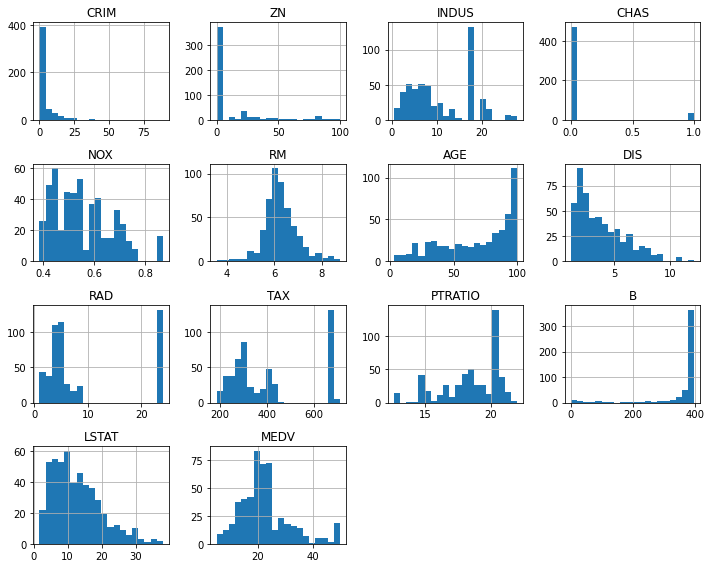

In [25]:
dataset.hist(figsize=(10, 8), bins=20)
pyplot.tight_layout()

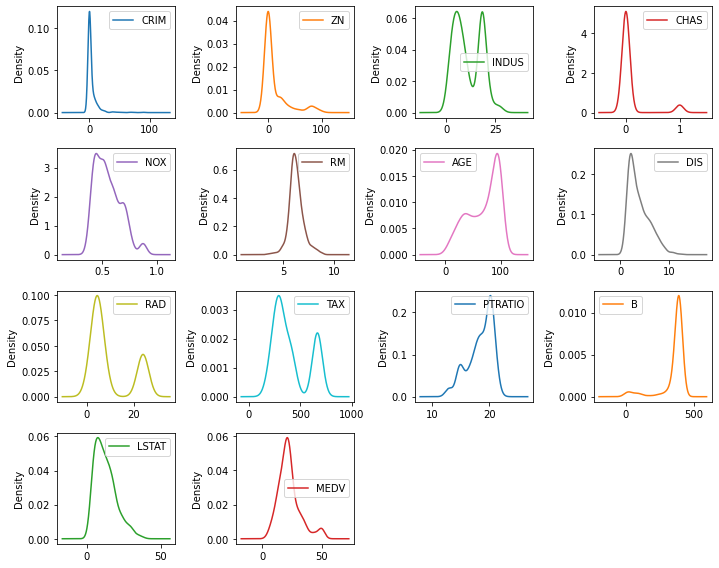

In [26]:
ax = dataset.plot(kind='density', subplots=True, layout=(4, 4), figsize=(10, 8), sharex=False, ylabel=False)
pyplot.tight_layout()

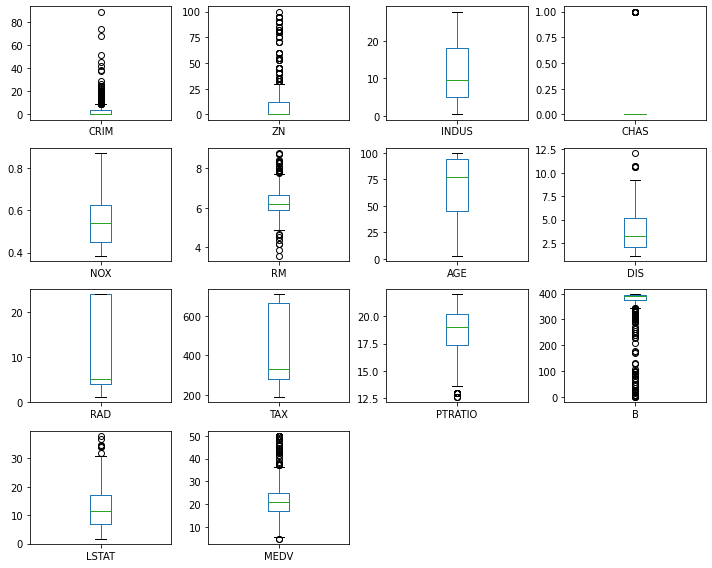

In [27]:
dataset.plot(kind='box',
             figsize=(10, 8),
             subplots=True,
             layout=(4, 4),
             sharex=False,
             sharey=False)
pyplot.tight_layout()

### 多元图

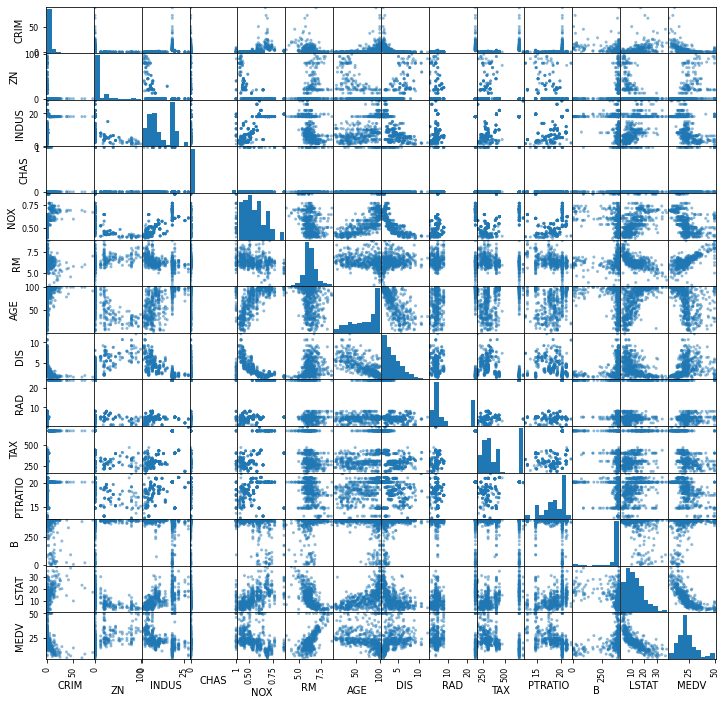

In [28]:
scatter_matrix(dataset, figsize=(12, 12));

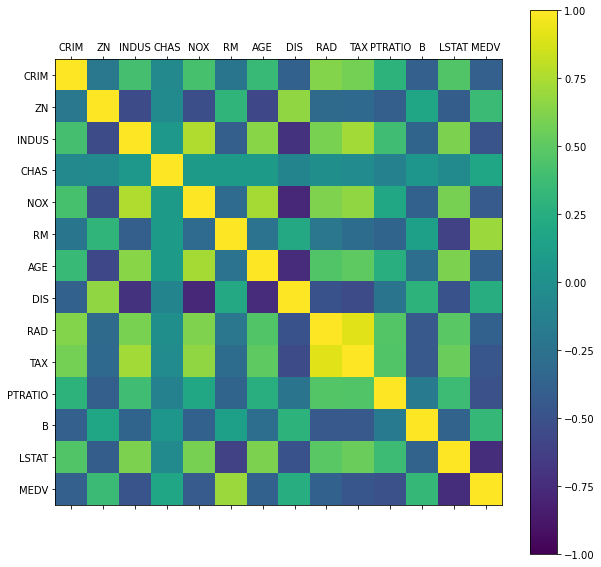

In [29]:
fig = pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(dataset.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cax)
ticks = numpy.arange(0, 14, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)  # 默认的ticks不是连续的，所以要设置连续的ticks
ax.set_xticklabels(names)
ax.set_yticklabels(names); # 只会给已有的tick添加label，因此要先设置tick，再设置name

根据数据分布，可以从以下几个方面考虑：
1. 进行特征选择以移除最相关的属性。
2. 对数据集进行归一化，以减少不同规模的影响。
3. 标准化数据集以减少不同分布的影响。

## 创建验证集

In [30]:
array = dataset.values
X = array[:, :-1]
Y = array[:, -1]
validation_size = 0.2
X_train, X_validation, Y_train, Y_validation = train_test_split(
    X, Y, test_size=validation_size, random_state=seed)

## 评估算法

In [31]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

models = {}
models['LR'] = LinearRegression()
models['LASSO'] = Lasso()
models['EN'] = ElasticNet()
models['KNN'] = KNeighborsRegressor()
models['CART'] = DecisionTreeRegressor()
models['SVR'] = SVR()

results = {}
for name, model in models.items():
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model,
                                 X_train,
                                 Y_train,
                                 cv=kfold,
                                 scoring=scoring)
    results[name] = cv_results
    print("{:<6}: {:.3f} ({:.3f})".format(name, cv_results.mean(), cv_results.std()))

LR    : -22.006 (12.189)
LASSO : -27.106 (13.166)
EN    : -27.923 (13.156)
KNN   : -39.809 (16.508)
CART  : -26.713 (19.956)
SVR   : -67.825 (32.802)


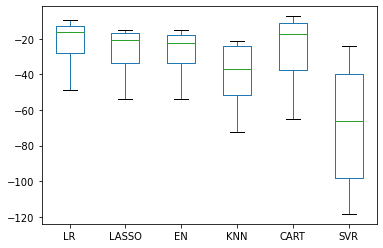

In [32]:
pd.DataFrame(results).plot(kind='box');

## 评估算法：标准化

In [33]:
pipelines = {}
pipelines["ScaleLR"] = Pipeline([('Scalar', StandardScaler()), ('LR', LinearRegression())])
pipelines["ScaleLASSO"] = Pipeline([('Scalar', StandardScaler()), ('LASSO', Lasso())])
pipelines["ScaleEN"] = Pipeline([('Scalar', StandardScaler()), ('EN', ElasticNet())])
pipelines["ScaleKNN"] = Pipeline([('Scalar', StandardScaler()), ('KNN', KNeighborsRegressor())])
pipelines["ScaleCART"] = Pipeline([('Scalar', StandardScaler()), ('CART', DecisionTreeRegressor())])
pipelines["ScaleSVR"] = Pipeline([('Scalar', StandardScaler()), ('SVR', SVR())])

results = {}
for name, model in pipelines.items():
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results[name] = cv_results
    print("{:<10}: {:3f} ({:3f})".format(name, cv_results.mean(), cv_results.std()))

ScaleLR   : -22.006009 (12.188886)
ScaleLASSO: -27.205896 (12.124418)
ScaleEN   : -28.301160 (13.609110)
ScaleKNN  : -21.456867 (15.016218)
ScaleCART : -25.215047 (16.019852)
ScaleSVR  : -29.570433 (18.052964)


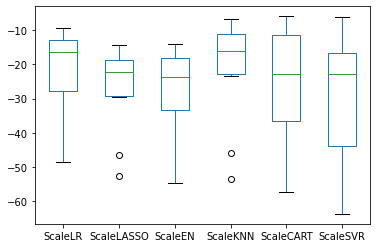

In [34]:
pd.DataFrame(results).plot(kind="box");

## 算法调优

In [35]:
scaler = StandardScaler().fit(X_train)
rescaleX = scaler.transform(X_train)
k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
param_graid = {'n_neighbors': k_values}

model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model,
                    param_grid=param_graid,
                    scoring=scoring,
                    cv=kfold)
grid_result = grid.fit(rescaleX, Y_train)

In [36]:
print("Best: {:3f} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
print()
for mean, std, param in zip(means, stds, params):
    print("{:.3f} ({:.3f}) width: {}".format(mean, std, param))

Best: -19.497829 using {'n_neighbors': 1}

-19.498 (15.770) width: {'n_neighbors': 1}
-19.978 (13.804) width: {'n_neighbors': 3}
-21.271 (14.834) width: {'n_neighbors': 5}
-21.577 (14.953) width: {'n_neighbors': 7}
-21.001 (14.701) width: {'n_neighbors': 9}
-21.490 (14.867) width: {'n_neighbors': 11}
-21.269 (14.455) width: {'n_neighbors': 13}
-21.968 (14.210) width: {'n_neighbors': 15}
-22.740 (14.493) width: {'n_neighbors': 17}
-23.507 (14.903) width: {'n_neighbors': 19}
-24.240 (15.157) width: {'n_neighbors': 21}


书上是上面的代码，但是感觉因为对所有数据进行标准化，也会存在数据泄露的问题，可以结合`pipeline`一起用：

In [37]:
# 设置pipe
pipe = Pipeline([('Scalar', StandardScaler()), ('KNN', KNeighborsRegressor())])
# 设置kfold
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
# 设置grid参数
k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
param_graid = {'KNN__n_neighbors': k_values}  # 如果结合pipe，可以用双下划线指定pipe的模型

grid = GridSearchCV(estimator=pipe,
                    param_grid=param_graid,
                    scoring=scoring,
                    cv=kfold)

grid_result = grid.fit(X_train, Y_train)

In [38]:
print("Best: {:3f} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
print()
for mean, std, param in zip(means, stds, params):
    print("{:.3f} ({:.3f}) width: {}".format(mean, std, param))

Best: -19.493073 using {'KNN__n_neighbors': 1}

-19.493 (15.772) width: {'KNN__n_neighbors': 1}
-19.774 (13.239) width: {'KNN__n_neighbors': 3}
-21.457 (15.016) width: {'KNN__n_neighbors': 5}
-21.221 (14.193) width: {'KNN__n_neighbors': 7}
-21.194 (14.761) width: {'KNN__n_neighbors': 9}
-21.495 (14.751) width: {'KNN__n_neighbors': 11}
-21.509 (14.760) width: {'KNN__n_neighbors': 13}
-22.083 (14.254) width: {'KNN__n_neighbors': 15}
-22.770 (14.595) width: {'KNN__n_neighbors': 17}
-23.674 (14.893) width: {'KNN__n_neighbors': 19}
-24.330 (15.014) width: {'KNN__n_neighbors': 21}


## 集成模型

In [39]:
ensembles = {}
ensembles['AB'] = Pipeline([('Scaler', StandardScaler()), ('AB', AdaBoostRegressor())])
ensembles['GBM'] = Pipeline([('Scaler', StandardScaler()), ('GBM', GradientBoostingRegressor())])
ensembles['RF'] = Pipeline([('Scaler', StandardScaler()), ('RF', RandomForestRegressor())])
ensembles['ET'] = Pipeline([('Scaler', StandardScaler()), ('ET', ExtraTreesRegressor())])

results = {}
for name, model in ensembles.items():
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model,
                                 X_train,
                                 Y_train,
                                 cv=kfold,
                                 scoring=scoring)
    results[name] = cv_results
    print("{:<5}: {:.3f} ({:.3f})".format(name, cv_results.mean(),
                                           cv_results.std()))

AB   : -15.942 (8.692)
GBM  : -10.877 (8.507)
RF   : -12.885 (9.990)
ET   : -9.103 (6.616)


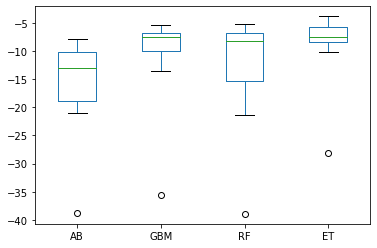

In [40]:
pd.DataFrame(results).plot(kind="box");

## 集成方法调优

In [41]:
scaler = StandardScaler().fit(X_train)
rescaleX = scaler.transform(X_train)

param_grid = {"n_estimators": [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]}
model = ExtraTreesRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model,
                     param_grid=param_grid,
                     scoring=scoring,
                     cv=kfold)
grid_result = grid.fit(rescaleX, Y_train)

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
print()

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print("{:3f} ({:3f}) with {}".format(mean, std, param))

Best: -8.97426487965323 using {'n_estimators': 400}

-9.484884 (6.042790) with {'n_estimators': 50}
-9.179690 (6.732852) with {'n_estimators': 100}
-9.423186 (7.015616) with {'n_estimators': 150}
-9.223148 (6.821735) with {'n_estimators': 200}
-9.282049 (6.598769) with {'n_estimators': 250}
-9.105590 (6.423885) with {'n_estimators': 300}
-9.044409 (6.562096) with {'n_estimators': 350}
-8.974265 (6.730690) with {'n_estimators': 400}
-9.120796 (6.618747) with {'n_estimators': 450}
-9.046245 (6.599090) with {'n_estimators': 500}


## 最终的模型

In [42]:
scaler = StandardScaler().fit(X_train)
rescaleX = scaler.transform(X_train)
model = GradientBoostingRegressor(random_state=seed, n_estimators=250)
model.fit(rescaleX, Y_train)

rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print(mean_squared_error(Y_validation, predictions))

11.585658327248112


# 两分类机器学习案例

## 读取数据

In [43]:
import numpy
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier  # 和书上相比，添加一个lightgbm的模型

dataset = read_csv("sonar.all-data", header=None)

## 分析数据

### 描述性统计

In [44]:
dataset.shape

(208, 61)

In [45]:
set_option('max_rows', 100)
dataset.dtypes

0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
16    float64
17    float64
18    float64
19    float64
20    float64
21    float64
22    float64
23    float64
24    float64
25    float64
26    float64
27    float64
28    float64
29    float64
30    float64
31    float64
32    float64
33    float64
34    float64
35    float64
36    float64
37    float64
38    float64
39    float64
40    float64
41    float64
42    float64
43    float64
44    float64
45    float64
46    float64
47    float64
48    float64
49    float64
50    float64
51    float64
52    float64
53    float64
54    float64
55    float64
56    float64
57    float64
58    float64
59    float64
60     object
dtype: object

In [46]:
set_option('display.precision', 3)
dataset.head(10)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.020,0.037,0.043,0.021,0.095,0.099,0.154,0.160,0.311,0.211,...,0.003,0.006,0.016,0.007,0.017,0.018,0.008,0.009,0.003,R
1,0.045,0.052,0.084,0.069,0.118,0.258,0.216,0.348,0.334,0.287,...,0.008,0.009,0.005,0.009,0.019,0.014,0.005,0.005,0.004,R
2,0.026,0.058,0.110,0.108,0.097,0.228,0.243,0.377,0.560,0.619,...,0.023,0.017,0.009,0.018,0.024,0.032,0.016,0.009,0.008,R
3,0.010,0.017,0.062,0.021,0.021,0.037,0.110,0.128,0.060,0.126,...,0.012,0.004,0.015,0.009,0.007,0.005,0.004,0.004,0.012,R
4,0.076,0.067,0.048,0.039,0.059,0.065,0.121,0.247,0.356,0.446,...,0.003,0.005,0.011,0.011,0.002,0.007,0.005,0.011,0.009,R
5,0.029,0.045,0.028,0.017,0.038,0.099,0.120,0.183,0.210,0.304,...,0.004,0.001,0.004,0.001,0.009,0.006,0.003,0.005,0.006,R
6,0.032,0.096,0.132,0.141,0.167,0.171,0.073,0.140,0.208,0.351,...,0.020,0.025,0.013,0.007,0.014,0.009,0.014,0.004,0.010,R
7,0.052,0.055,0.084,0.032,0.116,0.092,0.103,0.061,0.146,0.284,...,0.008,0.012,0.004,0.012,0.010,0.009,0.005,0.005,0.005,R
8,0.022,0.037,0.048,0.048,0.065,0.059,0.075,0.010,0.068,0.149,...,0.015,0.013,0.015,0.006,0.005,0.006,0.009,0.006,0.002,R
9,0.016,0.017,0.035,0.007,0.019,0.067,0.106,0.070,0.096,0.025,...,0.009,0.022,0.018,0.008,0.007,0.003,0.004,0.006,0.004,R


In [47]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
0,208.0,0.029,0.023,1.500e-03,0.013,0.023,0.036,0.137
1,208.0,0.038,0.033,6.000e-04,0.016,0.031,0.048,0.234
2,208.0,0.044,0.038,1.500e-03,0.019,0.034,0.058,0.306
3,208.0,0.054,0.047,5.800e-03,0.024,0.044,0.065,0.426
4,208.0,0.075,0.056,6.700e-03,0.038,0.062,0.100,0.401
5,208.0,0.105,0.059,1.020e-02,0.067,0.092,0.134,0.382
6,208.0,0.122,0.062,3.300e-03,0.081,0.107,0.154,0.373
7,208.0,0.135,0.085,5.500e-03,0.080,0.112,0.170,0.459
8,208.0,0.178,0.118,7.500e-03,0.097,0.152,0.233,0.683
9,208.0,0.208,0.134,1.130e-02,0.111,0.182,0.269,0.711


In [48]:
dataset.groupby(60).size()

60
M    111
R     97
dtype: int64

## 数据可视化

### 单变量图

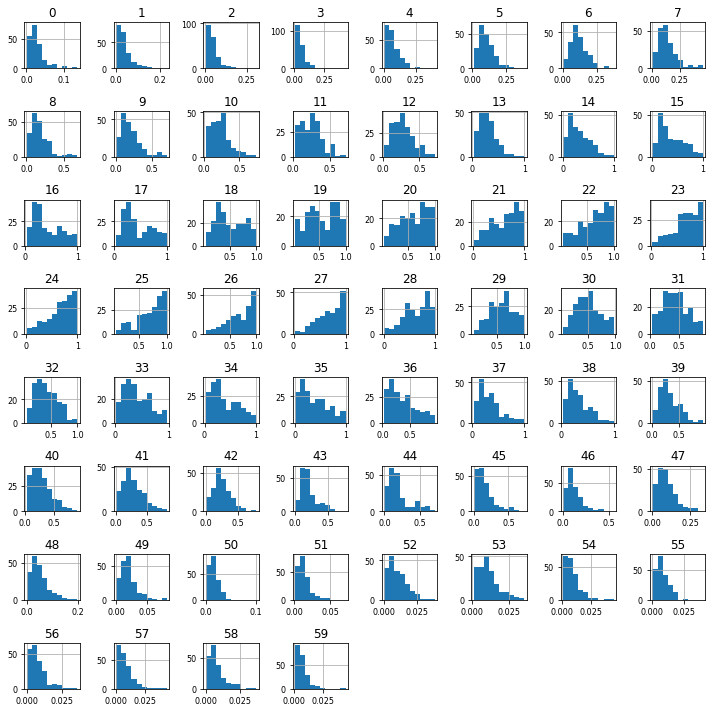

In [49]:
dataset.hist(figsize=(10, 10), xlabelsize=8, ylabelsize=8)
pyplot.tight_layout()

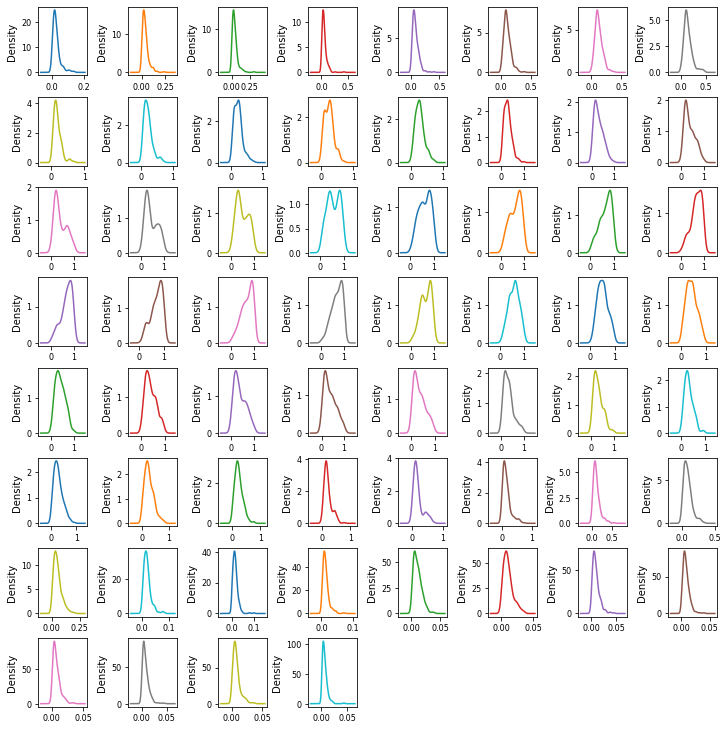

In [50]:
dataset.plot(kind='density',
             figsize=(10, 10),
             subplots=True,
             layout=(8, 8),
             sharex=False,
             legend=False,
             fontsize=8)
pyplot.tight_layout(pad=0.2)

可见，大部分的数据都存在一些偏度，因此如果采用`Box-Cox`变换，可能会有用。
- [Box-Cox Transformation: Explained](https://towardsdatascience.com/box-cox-transformation-explained-51d745e34203)

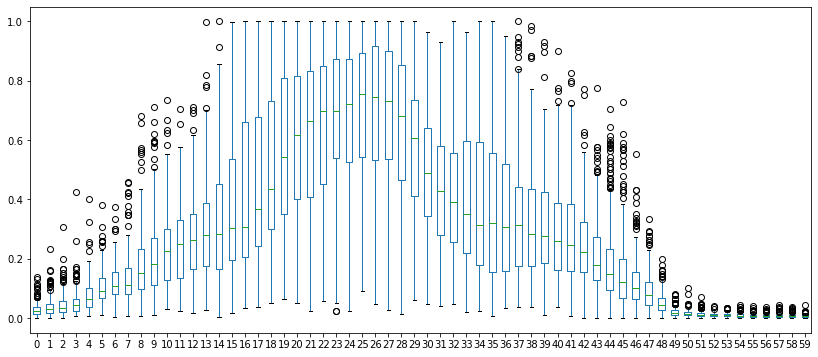

In [51]:
# 按照书上的例子会报错，不能添加subplots=True参数，不知道为什么
dataset.plot(kind='box', figsize=(14, 6));

### 多变量图

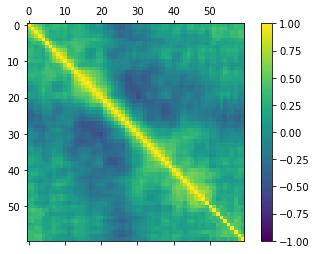

In [52]:
fig = pyplot.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(dataset.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cax);

## 创建验证集

In [53]:
array = dataset.values
X = array[:, :-1].astype(float)
Y = array[:, -1]
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(
    X, Y, test_size=validation_size, random_state=seed)

## 评估算法

In [54]:
num_folds = 10
scoring = 'accuracy'
models = {
    'LR': LogisticRegression(),
    'LDA': LinearDiscriminantAnalysis(),
    'KNN': KNeighborsClassifier(),
    'CART': DecisionTreeClassifier(),
    'NB': GaussianNB(),
    'SVM': SVC()
}

results = {}
for name, model in models.items():
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results[name] = cv_results
    print("{:<5}: {:.3f} ({:.3f})".format(name, cv_results.mean(), cv_results.std()))

LR   : 0.778 (0.088)
LDA  : 0.779 (0.094)
KNN  : 0.759 (0.106)
CART : 0.721 (0.096)
NB   : 0.683 (0.136)
SVM  : 0.765 (0.088)


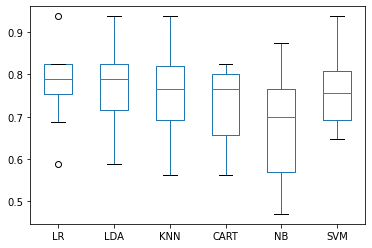

In [55]:
pd.DataFrame(results).plot(kind='box');

## 评估算法：标准化

In [56]:
pipelines = {}
pipelines['ScaleLR'] = Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])
pipelines['ScaleLDA'] = Pipeline([('Scaler', StandardScaler()), ('LDA', LinearDiscriminantAnalysis())])
pipelines['ScaleKNN'] = Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])
pipelines['ScaleCART'] = Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeClassifier())])
pipelines['ScaleNB'] = Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])
pipelines['ScaleSVM'] = Pipeline([('Scaler', StandardScaler()), ('SVM', SVC())])

results = {}
for name, model in pipelines.items():
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results[name] = cv_results
    print("{:<10}: {:.3f} ({:.3f})".format(name, cv_results.mean(), cv_results.std()))

ScaleLR   : 0.754 (0.068)
ScaleLDA  : 0.779 (0.094)
ScaleKNN  : 0.808 (0.108)
ScaleCART : 0.722 (0.118)
ScaleNB   : 0.683 (0.136)
ScaleSVM  : 0.826 (0.082)


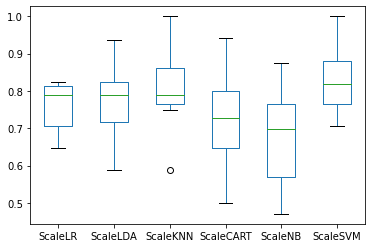

In [57]:
pd.DataFrame(results).plot(kind='box');

## 算法调优

### KNN调优

In [58]:
scaler = StandardScaler().fit(X_train)
rescaleX = scaler.transform(X_train)
neighbors = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
param_graid = {'n_neighbors': neighbors}

model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model,
                    param_grid=param_graid,
                    scoring=scoring,
                    cv=kfold)
grid_result = grid.fit(rescaleX, Y_train)

In [59]:
print("Best: {:3f} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
print()
for mean, std, param in zip(means, stds, params):
    print("{:.3f} ({:.3f}) width: {}".format(mean, std, param))

Best: 0.836029 using {'n_neighbors': 1}

0.836 (0.079) width: {'n_neighbors': 1}
0.814 (0.088) width: {'n_neighbors': 3}
0.814 (0.097) width: {'n_neighbors': 5}
0.778 (0.120) width: {'n_neighbors': 7}
0.730 (0.099) width: {'n_neighbors': 9}
0.742 (0.074) width: {'n_neighbors': 11}
0.711 (0.106) width: {'n_neighbors': 13}
0.723 (0.081) width: {'n_neighbors': 15}
0.699 (0.073) width: {'n_neighbors': 17}
0.711 (0.091) width: {'n_neighbors': 19}
0.699 (0.091) width: {'n_neighbors': 21}


### SVM调优

In [60]:
scaler = StandardScaler().fit(X_train)
rescaleX = scaler.transform(X_train)
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_graid = {'C':c_values, 'kernel':kernel_values}

model = SVC()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model,
                    param_grid=param_graid,
                    scoring=scoring,
                    cv=kfold)
grid_result = grid.fit(rescaleX, Y_train)

In [61]:
print("Best: {:3f} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
print()
for mean, std, param in zip(means, stds, params):
    print("{:.3f} ({:.3f}) width: {}".format(mean, std, param))

Best: 0.850000 using {'C': 1.7, 'kernel': 'rbf'}

0.749 (0.070) width: {'C': 0.1, 'kernel': 'linear'}
0.583 (0.127) width: {'C': 0.1, 'kernel': 'poly'}
0.601 (0.184) width: {'C': 0.1, 'kernel': 'rbf'}
0.713 (0.117) width: {'C': 0.1, 'kernel': 'sigmoid'}
0.754 (0.082) width: {'C': 0.3, 'kernel': 'linear'}
0.644 (0.100) width: {'C': 0.3, 'kernel': 'poly'}
0.742 (0.082) width: {'C': 0.3, 'kernel': 'rbf'}
0.749 (0.070) width: {'C': 0.3, 'kernel': 'sigmoid'}
0.766 (0.070) width: {'C': 0.5, 'kernel': 'linear'}
0.705 (0.098) width: {'C': 0.5, 'kernel': 'poly'}
0.785 (0.069) width: {'C': 0.5, 'kernel': 'rbf'}
0.761 (0.066) width: {'C': 0.5, 'kernel': 'sigmoid'}
0.760 (0.083) width: {'C': 0.7, 'kernel': 'linear'}
0.760 (0.094) width: {'C': 0.7, 'kernel': 'poly'}
0.814 (0.060) width: {'C': 0.7, 'kernel': 'rbf'}
0.761 (0.080) width: {'C': 0.7, 'kernel': 'sigmoid'}
0.765 (0.067) width: {'C': 0.9, 'kernel': 'linear'}
0.790 (0.094) width: {'C': 0.9, 'kernel': 'poly'}
0.808 (0.063) width: {'C': 0.9, 

## 集成模型

In [62]:
ensembles = {}
ensembles['AB'] = Pipeline([('Scaler', StandardScaler()), ('AB', AdaBoostClassifier())])
ensembles['GBM'] = Pipeline([('Scaler', StandardScaler()), ('GBM', GradientBoostingClassifier())])
ensembles['RF'] = Pipeline([('Scaler', StandardScaler()), ('RF', RandomForestClassifier())])
ensembles['ET'] = Pipeline([('Scaler', StandardScaler()), ('ET', ExtraTreesClassifier())])
ensembles['LGB'] = Pipeline([('Scaler', StandardScaler()), ('LGB', LGBMClassifier())])

results = {}
for name, model in ensembles.items():
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model,
                                 X_train,
                                 Y_train,
                                 cv=kfold,
                                 scoring=scoring)
    results[name] = cv_results
    print("{:<5}: {:.3f} ({:.3f})".format(name, cv_results.mean(),
                                           cv_results.std()))

AB   : 0.783 (0.072)
GBM  : 0.796 (0.150)
RF   : 0.820 (0.065)
ET   : 0.861 (0.083)
LGB  : 0.832 (0.095)


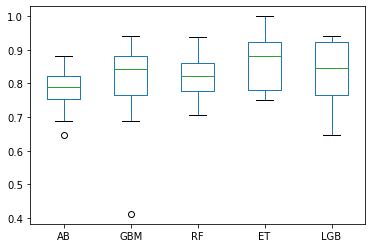

In [63]:
pd.DataFrame(results).plot(kind='box');

## 集成方法调优

In [64]:
scaler = StandardScaler().fit(X_train)
rescaleX = scaler.transform(X_train)

param_grid = {
    "n_estimators": [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
}
model = ExtraTreesClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    scoring=scoring,
                    cv=kfold)
grid_result = grid.fit(rescaleX, Y_train)

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
print()

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print("{:3f} ({:3f}) with {}".format(mean, std, param))

Best: 0.8860294117647058 using {'n_estimators': 450}

0.837868 (0.065115) with {'n_estimators': 50}
0.862500 (0.070011) with {'n_estimators': 100}
0.868015 (0.084996) with {'n_estimators': 150}
0.868750 (0.086002) with {'n_estimators': 200}
0.868750 (0.074153) with {'n_estimators': 250}
0.844118 (0.060594) with {'n_estimators': 300}
0.862500 (0.070011) with {'n_estimators': 350}
0.868015 (0.079712) with {'n_estimators': 400}
0.886029 (0.067751) with {'n_estimators': 450}
0.880147 (0.079555) with {'n_estimators': 500}


## 最终模型

本地跑的结果最好的模型是ExtraTreesClassifier，但是书上的是SVC，这里就按照书上的来吧：

In [65]:
scaler = StandardScaler().fit(X_train)
rescaleX = scaler.transform(X_train)
model = SVC(C=1.5)
model.fit(rescaleX, Y_train)
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)

In [66]:
accuracy_score(Y_validation, predictions)

0.8571428571428571

In [67]:
print(confusion_matrix(Y_validation, predictions))

[[23  4]
 [ 2 13]]


In [68]:
print(classification_report(Y_validation, predictions))

              precision    recall  f1-score   support

           M       0.92      0.85      0.88        27
           R       0.76      0.87      0.81        15

    accuracy                           0.86        42
   macro avg       0.84      0.86      0.85        42
weighted avg       0.86      0.86      0.86        42

